In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('../data/processed/beijing.csv', index_col = 0)
df.head()

,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,Iprec,hour_x,hour_y,month_x,month_y
time,,,,,,,,,,,
2010-01-01 23:00:00,129.0,-17.0,41.0,1020.0,-5.0,0.0,0.0,0.965926,-0.258819,0.866025,0.5
2010-01-02 00:00:00,148.0,-16.0,38.0,1020.0,-4.0,0.0,0.0,1.000000,0.000000,0.866025,0.5
2010-01-02 01:00:00,159.0,-15.0,42.0,1020.0,-4.0,0.0,0.0,0.965926,0.258819,0.866025,0.5
2010-01-02 02:00:00,181.0,-11.0,63.5,1021.0,-5.0,0.0,0.0,0.866025,0.500000,0.866025,0.5
2010-01-02 03:00:00,138.0,-7.0,85.0,1022.0,-5.0,0.0,0.0,0.707107,0.707107,0.866025,0.5


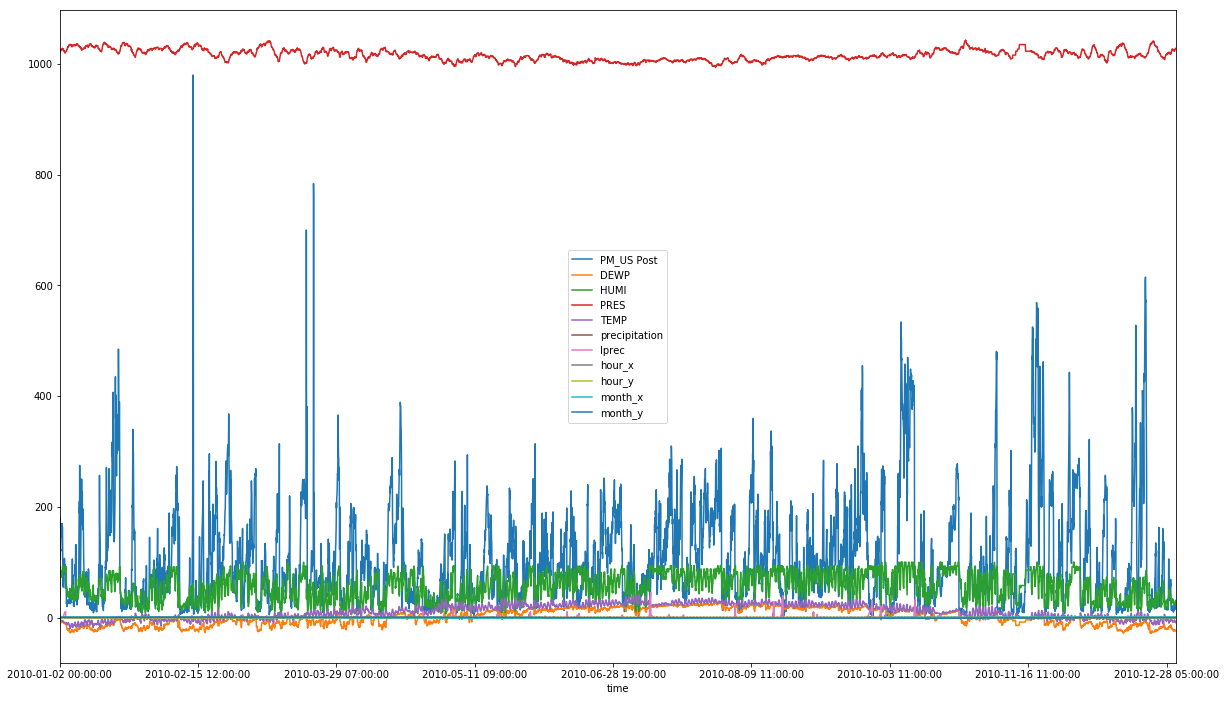

In [4]:
df['2010-01-02':'2010-12-31'].plot(figsize=(20, 12))

In [5]:
scaler = StandardScaler()

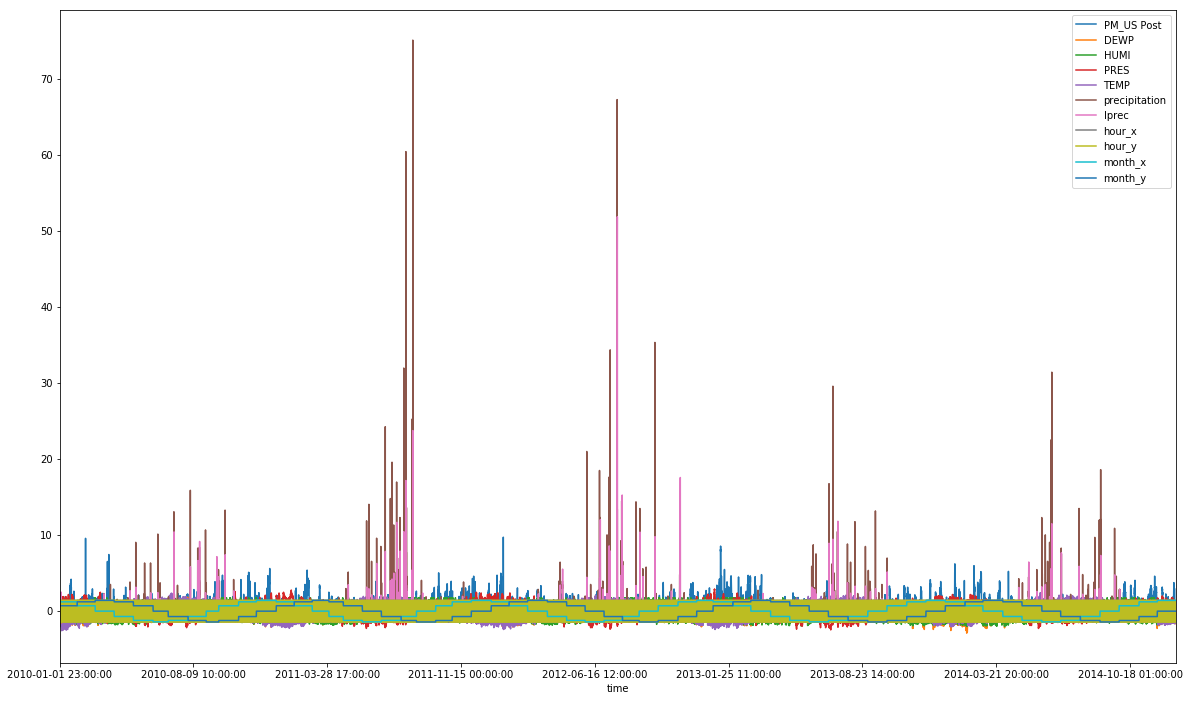

In [6]:
train_df = df[:'2014-12-31']
scaled_train_df = pd.DataFrame(scaler.fit_transform(train_df), 
                         index=train_df.index, columns=train_df.columns)
scaled_train_df.plot(figsize=(20, 12))

In [7]:
from numpy import array
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, TimeDistributed
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model
from keras.layers import Input
from keras import optimizers

/home/ahua/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [9]:
input_enc = len(df.columns)
dropout = 0.5

input_enc_layer = Input(shape=(None, input_enc))
layer = LSTM(25,
#                               stateful=False
#                               activation=enc_act[0], recurrent_activation=enc_rec_act[0],
#                               activity_regularizer=regularizers.l1(10e-100),
#                               batch_input_shape=batch_input_shape,
                               return_sequences=True,
#                               return_state=True,
                               dropout=dropout,
                               #recurrent_dropout=dropout
                              )(input_enc_layer)

layer = LSTM(50,
#                               stateful=False
#                               activation=enc_act[0], recurrent_activation=enc_rec_act[0],
#                               activity_regularizer=regularizers.l1(10e-100),
#                               batch_input_shape=batch_input_shape,
                               return_sequences=True,
#                               return_state=True,
                               dropout=dropout,
                               #recurrent_dropout=dropout
                              )(layer)

layer = LSTM(25,
#                               stateful=False
#                               activation=enc_act[0], recurrent_activation=enc_rec_act[0],
#                               activity_regularizer=regularizers.l1(10e-100),
#                               batch_input_shape=batch_input_shape,
                               return_sequences=False,
#                               return_state=True,
                               dropout=dropout,
                               #recurrent_dropout=dropout
                              )(layer)


layer = Dense(input_enc,activation='linear')(layer)


#output_layer = TimeDistributed(Dense(input_enc, activation='linear'))(layer)

ops = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = Model(inputs=input_enc_layer, outputs=layer)
model.compile(optimizer=ops,
              loss='mse',
              metrics=['mse'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 11)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          3700      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 50)          15200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                286       
Total params: 26,786
Trainable params: 26,786
Non-trainable params: 0
_________________________________________________________________


In [11]:
def lookback_window(input_df, window_size, step=1):
    #input_array: 2D np array of size (num_timesteps, window_size)
    #window_size: int, size of the window to slice array
    #step: int, number of timestep to increment window by
    #return: a 3D array of size (batch_size, window_size, num_features) 

    samples = input_df.shape[0] - window_size + step
    sensors = input_df.shape[1]
    
    array = np.empty(shape=(int(samples/step), window_size, sensors))
    index = pd.DataFrame(data=np.empty(int(samples/step)))
                     
    for s in range(int(samples/step)):
        array[s, :, :] = input_df.iloc[s*step : s*step + window_size, :]
        index.iloc[s] = input_df.index[s*step + window_size - 1]
        
    return index, array

In [12]:
val_split = 0.2
window_size = 24
step = 1

indices, input_train_enc = lookback_window(scaled_train_df, window_size, step)

train_size_enc = int(input_train_enc.shape[0]*(1 - val_split))
val_data_enc    = input_train_enc[train_size_enc:-1, :, :]
input_train_enc = input_train_enc[0:train_size_enc, :, :]

history = model.fit(input_train_enc[:,0:-1,:], input_train_enc[:,-1,:],
                    epochs=10,
                    batch_size=256,
                    shuffle=False,
                    validation_data=(val_data_enc[:,0:-1,:], val_data_enc[:,-1,:]),
                    verbose=1).history

model.save('weights.h5')

Train on 33347 samples, validate on 8336 samples
Epoch 1/10
33347/33347 [==============================] - 9s 269us/step - loss: 0.8165 - mean_squared_error: 0.8165 - val_loss: 0.3907 - val_mean_squared_error: 0.3907
Epoch 2/10
33347/33347 [==============================] - 10s 302us/step - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.2674 - val_mean_squared_error: 0.2674
Epoch 3/10
33347/33347 [==============================] - 15s 442us/step - loss: 0.5760 - mean_squared_error: 0.5760 - val_loss: 0.2535 - val_mean_squared_error: 0.2535
Epoch 4/10
33347/33347 [==============================] - 18s 526us/step - loss: 0.5380 - mean_squared_error: 0.5380 - val_loss: 0.2363 - val_mean_squared_error: 0.2363
Epoch 5/10
33347/33347 [==============================] - 17s 513us/step - loss: 0.5128 - mean_squared_error: 0.5128 - val_loss: 0.2264 - val_mean_squared_error: 0.2264
Epoch 6/10
33347/33347 [==============================] - 16s 492us/step - loss: 0.4872 - mean_squared_erro

In [ ]:
window = 24
p = 0.1
rg = 1


train_index, batches = lookback_window(scaled_train_df, window_size, step)
train_prediction = model.predict(batches[:,0:-1,:])

In [ ]:
train = scaled_train_df.loc[train_index.iloc[:,0]]  #these are the valid train indices according to the mask
train_error = (train.values - train_prediction)**2
train_error = pd.DataFrame(data=train_error, columns=scaled_train_df.columns,\
                           index=train.index)
train = pd.Series(data=train_error.mean(axis=1))
train_mean = train.rolling(window).mean().dropna()
train_std  = train.rolling(window).std().dropna()

In [ ]:
ax = train_mean.plot(figsize=(20, 10))
ax.set_title("anomaly score for beijing weather", fontsize=35)
ax.set_ylabel("anomaly score", fontsize=30)
ax.annotate('massive flood', xy=(20600, 100), xytext=(25000, 100),
            arrowprops=dict(facecolor='black', shrink=0.05), size = 'xx-large')
ax.annotate('heavy rain', xy=(13000, 20), xytext=(15000, 40),
            arrowprops=dict(facecolor='black', shrink=0.05), size = 'xx-large')
plt.savefig('../images/weather_train.png')

In [ ]:
set([d.split()[0] for d in train_mean.nlargest(50).index])

There seems to be two distinct large peaks during this period. Let's investigate what happened?

A quick search online reviewed that there was a [massive flood](https://en.wikipedia.org/wiki/July_2012_Beijing_flood) on 2012-07-21 in Beijing leading to the death of 79 people and caused 10 billion yuan worth of damage.

On 2011-08-26, heavy rain casued [flooding](http://www.chinadaily.com.cn/photo/2011-08/26/content_13198082.htm) in Beijing leading to traffic jams. There was no death reported and damage to infrastructure was not reported.

It appears that our model was able to catch large anamalies

In [17]:
test_df = df['2014-12-31':]
scaled_test_df = pd.DataFrame(scaler.transform(test_df), 
                         index=test_df.index, columns=test_df.columns)

In [18]:
test_index, batches = lookback_window(scaled_test_df, window_size, step)
test_prediction = model.predict(batches[:,0:-1,:])

In [19]:
test = scaled_test_df.loc[test_index.iloc[:,0]]  #these are the valid train indices according to the mask
test_error = np.absolute(test.values - test_prediction)**2
test_error = pd.DataFrame(data=test_error, columns=scaled_test_df.columns,\
                           index=test.index)
test = pd.Series(data=test_error.sum(axis=1))
test_mean = test.rolling(window).mean().dropna()
test_std  = test.rolling(window).std().dropna()

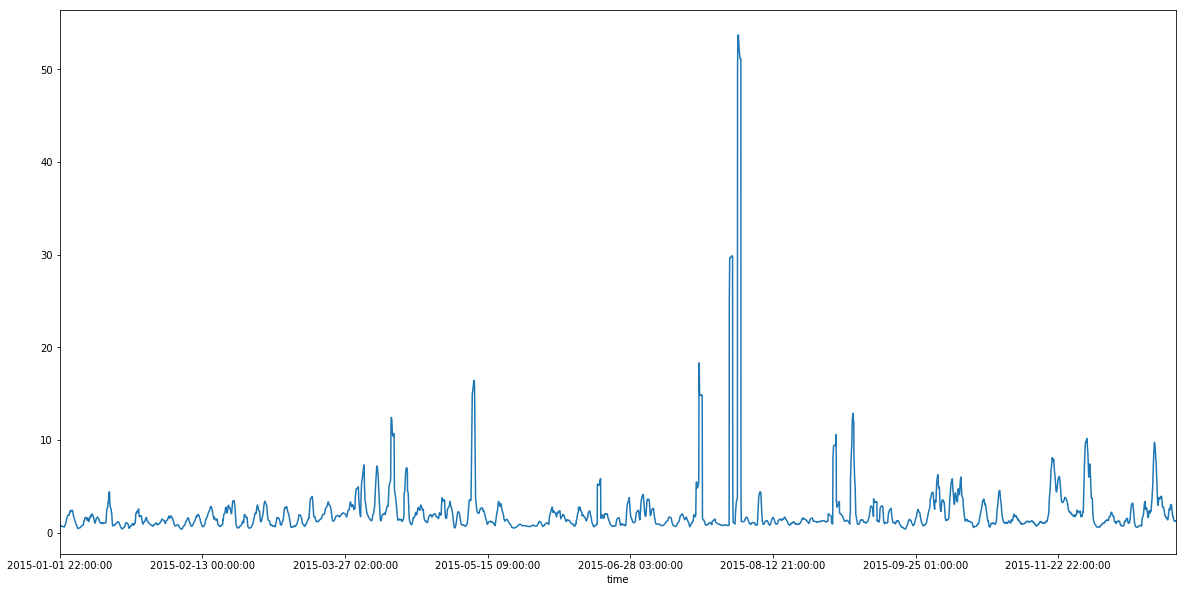

In [20]:
test_mean.plot(figsize=(20, 10))